In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import integrate, signal
from scipy.special import i0, i1
from scipy.optimize import fsolve, root, minimize, basinhopping
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# from toy_models import *
import warnings
warnings.filterwarnings('ignore')

%matplotlib widget

In [5]:
def norm_phi1(x):
    # Function to calculate the module of a vector phi1
    return np.sqrt(x[0]**2 + x[1]**2)

def norm_phi2(x):
    # Function to calculate the module of a vector phi2
    return np.sqrt(x[2]**2 + x[3]**2)

def B(x):
    '''x is the norm of the 2D vector.
    B returns I1(x) / (I0(x) * x) where I0 and I1 are the modified Bessel functions of the first kind.'''
    return i1(x) / (i0(x) * x)

def DiffE_phi_uvec(phi_l, om, T, J12, J1, J2):
    phi = phi_l[:4]
    l1 = phi_l[4]
    l2 = phi_l[5]
    coeff1 = T / J12
    coeff2 = 1 / J12
    return [coeff1 * phi[2] - B(norm_phi1(phi)) * phi[0] - coeff2 * J2 * om[2] + 2 * l1 * phi[0],
            coeff1 * phi[3] - B(norm_phi1(phi)) * phi[1] - coeff2 * J2 * om[3] + 2 * l1 * phi[1],
            coeff1 * phi[0] - B(norm_phi2(phi)) * phi[2] - coeff2 * J1 * om[0] + 2 * l2 * phi[2],
            coeff1 * phi[1] - B(norm_phi2(phi)) * phi[3] - coeff2 * J1 * om[1] + 2 * l2 * phi[3],
            phi[0]**2 + phi[1]**2 - 1,
            phi[2]**2 + phi[3]**2 - 1]

def check_constraint_comp(phi1, phi2, om1, om2, theta0):
    '''Return True if phi1 is in N(om1, theta0) and phi2 is in N(om2, theta0).'''
    return abs(phi1-om1) <= theta0 and abs(phi2-om2) <= theta0

def check_constraint_dec(phi1, phi2, om1, om2, theta0):
    '''Return True if phi1 is in N(om1, theta0) and phi2 is not in N(om2, theta0).'''
    return abs(phi1-om1) <= theta0 and abs(phi2-om2) > theta0

def Hess(phi, om, T, J12, J1, J2):
    '''Compute the hessisn matrix of the free energy.'''
    coeff1 = T / J12
    coeff2 = 1 / J12
    return np.array([[-coeff1 * np.cos(phi[0]-phi[1]) + coeff2 * J2 * np.cos(phi[0]-om[1]), 
                    coeff1 * np.cos(phi[0]-phi[1])],
                    [coeff1 * np.cos(phi[0]-phi[1]), 
                    coeff1 * np.cos(phi[0]-phi[1]) + coeff2 * J1 * np.cos(phi[1]-om[0])]])
# return np.array([[-coeff1 * np.cos(phi[0]-phi[1]) + coeff2 * J2 * np.cos(phi[0]-om[1]), 
    #                   coeff1 * np.cos(phi[0]-phi[1])],
    #                  [coeff1 * np.cos(phi[0]-phi[1]), 
    #                   coeff1 * np.cos(phi[0]-phi[1]) + coeff2 * J1 * np.cos(phi[1]-om[0])]])

def is_stable(phi, om, T, J12, J1, J2):
    J = Jac(phi, om, T, J12, J1, J2)
    # Compute the eigenvalues of the Jacobian matrix
   # eigenvalues, _ = np.linalg.eig(jac_matrix)
    # Check stability
    return np.all(np.real(np.linalg.eigvals(J))<0)

In [6]:
J12 = 100
Jmax = 10
J1 = Jmax
J2 = Jmax
T = 1
om1 = np.radians(30)
om2 = np.radians(-30)
theta0 = np.radians(20)

# generate random unit vectors for initial conditions
# phi1_i = np.random.rand(2)
# phi2_i = np.random.rand(2)
phi1_i = [np.cos(om1), np.sin(om1)]
phi2_i = [np.cos(om2), np.sin(om2)]
om = [np.cos(om1), np.sin(om1), np.cos(om2), np.sin(om2)]
# print('phi1_i =', phi1_i)
# print('phi2_i =', phi2_i)

phi_sol = fsolve(DiffE_phi_uvec, [np.cos(om1), np.sin(om1), np.cos(om2), np.sin(om2), 0.1, 0.1], args=(om, T, J12, J1, J2))

phi1 = np.arctan2(phi_sol[1], phi_sol[0])
phi2 = np.arctan2(phi_sol[3], phi_sol[2])
print('phi1 =', np.degrees(phi1))
print('phi2 =', np.degrees(phi2))

phi1 = -35.42029261137142
phi2 = 35.420292611371394


In [7]:
# create a data frame with the results
df_comp = pd.DataFrame(columns=['J12', 'J1', 'J2', 'T', 'om1', 'om2', 'theta0', 'phi'])
df_dec = pd.DataFrame(columns=['J12', 'J1', 'J2', 'T', 'om1', 'om2', 'theta0', 'phi'])

# solve the equation for different values of J12, Jmax and T

theta0 = np.radians(20)

T = 1
J12 = 10
# Jmax = 1
om2 = 0

for om1 in np.arange(0, np.pi, np.pi/60):
    for Jmax in 10/np.linspace(1, 30, 50):
        om = [np.cos(om1), np.sin(om1), np.cos(om2), np.sin(om2)]
        phi_i = [np.cos(om1), np.sin(om1), np.cos(om2), np.sin(om2), 0.1, 0.1]
        # solve the equation using fsolve
        phi_comp = fsolve(DiffE_phi_uvec, phi_i, args=(om, T, J12, Jmax, Jmax))
        phi_dec = fsolve(DiffE_phi_uvec, phi_i, args=(om, T, J12, Jmax, 0))

        # # store the results in the data frame
        df_comp = df_comp.append({'J12': J12, 'J1': Jmax, 'J2': Jmax, 'T': T, 'om1': om1, 'om2': om2, 'theta0': theta0, 'phi': phi_comp}, ignore_index=True)
        df_dec = df_dec.append({'J12': J12, 'J1': Jmax, 'J2': 0, 'T': T, 'om1': om1, 'om2': om2, 'theta0': theta0, 'phi': phi_dec}, ignore_index=True)


In [8]:
df_comp['phi1'] = df_comp.apply(lambda row: np.arctan2(row['phi'][1], row['phi'][0]), axis=1)
df_comp['phi2'] = df_comp.apply(lambda row: np.arctan2(row['phi'][3], row['phi'][2]), axis=1)
df_comp['is_sol'] = df_comp.apply(lambda row: check_constraint_comp(row['phi1'], row['phi2'], row['om1'], row['om2'], row['theta0']), axis=1)

df_dec['phi1'] = df_dec.apply(lambda row: np.arctan2(row['phi'][1], row['phi'][0]), axis=1)
df_dec['phi2'] = df_dec.apply(lambda row: np.arctan2(row['phi'][3], row['phi'][2]), axis=1)
df_dec['is_sol'] = df_dec.apply(lambda row: check_constraint_comp(row['phi1'], row['phi2'], row['om1'], row['om2'], row['theta0']), axis=1)

# # add column omega_diff
df_comp['omega_diff'] = df_comp.apply(lambda row: row['om1'] - row['om2'], axis=1)
df_dec['omega_diff'] = df_dec.apply(lambda row: row['om1'] - row['om2'], axis=1)

comp = df_comp[(df_comp['is_sol'] == True)]
dec = df_dec[(df_dec['is_sol'] == True)]

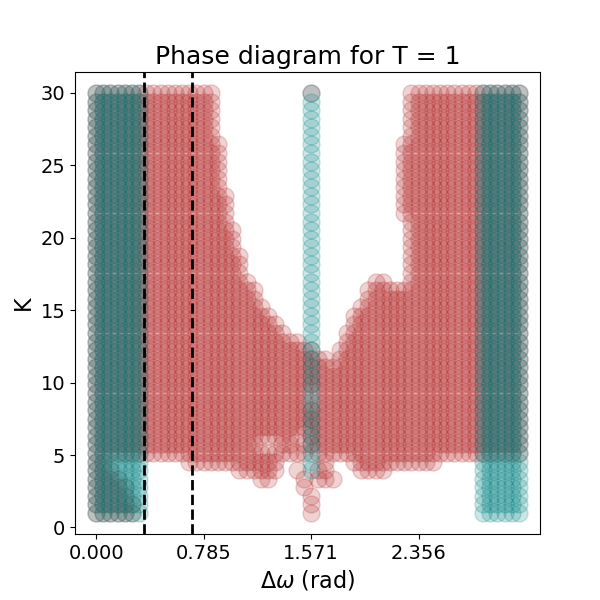

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Phase diagram for T = ' + str(T), fontsize=18)
ax.set_ylabel('K', fontsize=16)
# set x label as delta omega using latex 
ax.set_xlabel(r'$\Delta \omega$ (rad)', fontsize=16)
# ax.set_ylim(0, 10)
# ax.set_xlim(0, np.pi)
# ax.scatter(comp['omega_diff'], comp['T'], s=150, alpha=0.2, c='firebrick')
# ax.scatter(dec['omega_diff'], dec['T'], s=150, alpha=0.2, c='teal')
ax.scatter(comp['omega_diff'], comp['J12']/comp['J1'], s=150, alpha=0.2, c='firebrick')
ax.scatter(dec['omega_diff'], dec['J12']/dec['J1'], s=150, alpha=0.2, c='teal')
# increase the tick size and the label size
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks(np.arange(0, np.pi, np.pi/4))
# add vertical line at theta0
ax.axvline(x=theta0, color='black', linestyle='--', linewidth=2)
ax.axvline(x=2*theta0, color='black', linestyle='--', linewidth=2)
# save the figure in pdf 300 dpi
# plt.savefig('stica2.pdf', dpi=100, bbox_inches='tight')
plt.show()

In [14]:
def dot(a, b):
    '''Calculate dot product of two 2D vectors'''
    return np.dot(a, b)

def norm(v):
    '''Calculate norm of a 2D vector'''
    return np.sqrt(v[0]**2 + v[1]**2)

def constraint_phi1(x):
    '''Constraint that phi1 is a unit vector'''
    return x[0]**2 + x[1]**2 - 1

def constraint_phi2(x):
    '''Constraint that phi2 is a unit vector'''
    return x[2]**2 + x[3]**2 - 1


In [15]:
def free_energy(x, T, J12, J1, J2, omega1, omega2):
    '''phi1, phi2, omega1, omega2 are components of 2D vectors.
       x is a 1D array with the components of phi1 and phi2: [phi1_x, phi1_y, phi2_x, phi2_y]'''
    phi1 = x[:2]
    phi2 = x[2:4]
    return T/J12 * dot(phi1, phi2) + J1*J2/T * dot(omega1, omega2) - 1/J12 * (J2*dot(phi1, omega2) + J1*dot(phi2, omega1)) - np.log(i0(norm(phi1))) - np.log(i0(norm(phi2)))


In [20]:

from scipy.optimize import minimize, LinearConstraint
import numdifftools as nd

def find_minima(T, J12, J1, J2, omega1, omega2):
    # initial guess
    x0 = [1.0, 0.0, 1.0, 0.0]  # phi1 and phi2 start as unit vectors

    # define constraints
    cons = [{'type':'eq', 'fun':constraint_phi1}, {'type':'eq', 'fun':constraint_phi2}]

    # find minimum
    result = minimize(free_energy, x0, args=(T, J12, J1, J2, omega1, omega2), constraints=cons)

    if result.success:
        print('Minima found:', result.x)
        # If result.success is True, it means that the optimizer has found a minimum
        # However, it could be a local minimum. We are not checking here for a global minimum.
    else:
        print('Failed to find minimum:', result.message)
    
    # Check the Hessian matrix at the solution
    hes = nd.Hessian(lambda x: free_energy(x, T, J12, J1, J2, omega1, omega2))(result.x)
    print('Hessian matrix at the solution:', hes)

    # Check if it's a minimum
    eigenvalues = np.linalg.eigvals(hes)
    if np.all(eigenvalues > 0):
        print('The solution is a minimum.')
    elif np.all(eigenvalues < 0):
        print('The solution is a maximum.')
    else:
        print('The solution is a saddle point.')
    
    return result.x, hes, eigenvalues


In [28]:
sol = find_minima(T=1, J12=1, J1=1, J2=1, omega1=[np.cos(20), np.sin(20)], omega2=[np.cos(-20), np.sin(-20)])

# express the solution in polar coordinates
def polar(x):
    '''Convert a 2D vector to polar coordinates'''
    return np.array([norm(x), np.arctan2(x[1], x[0])])



Minima found: [ 0.13964573 -0.99020154  0.13964573  0.99020154]
Hessian matrix at the solution: [[-0.44459502 -0.0127276   1.          0.        ]
 [-0.0127276  -0.35614097  0.          1.        ]
 [ 1.          0.         -0.44459502  0.0127276 ]
 [ 0.          1.          0.0127276  -0.35614097]]
The solution is a saddle point.


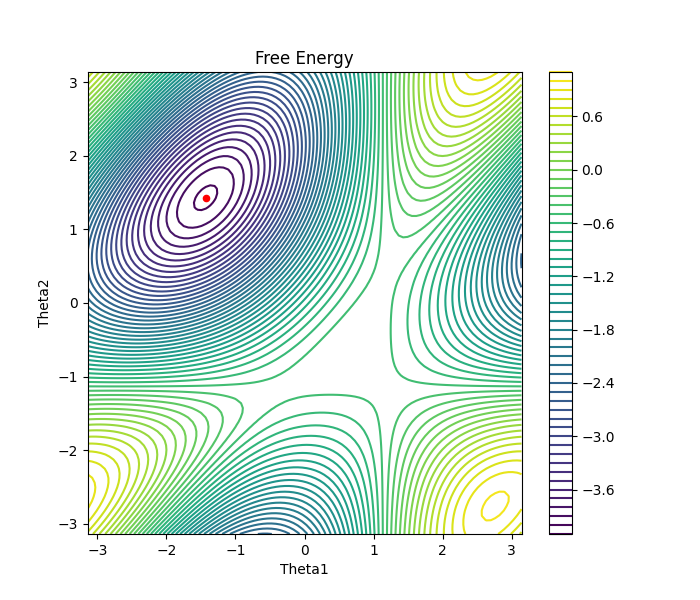

In [35]:
def free_energy_polar(theta, T, J12, J1, J2, omega1, omega2):
    '''theta = [theta1, theta2] are angles'''
    # Convert angles to Cartesian coordinates
    phi1 = [np.cos(theta[0]), np.sin(theta[0])]
    phi2 = [np.cos(theta[1]), np.sin(theta[1])]
    return T/J12 * dot(phi1, phi2) + J1*J2/T * dot(omega1, omega2) - 1/J12 * (J2*dot(phi1, omega2) + J1*dot(phi2, omega1)) - np.log(i0(norm(phi1))) - np.log(i0(norm(phi2)))


theta1_values = np.linspace(-np.pi, np.pi, 100)
theta2_values = np.linspace(-np.pi, np.pi, 100)
theta1_grid, theta2_grid = np.meshgrid(theta1_values, theta2_values)

#PARAMETERS
omega1=[np.cos(20), np.sin(20)]
omega2=[np.cos(-20), np.sin(-20)]
T = 1
J12 = 1
J1 = 1
J2 = 1

E_values = np.empty_like(theta1_grid)

for i in range(theta1_grid.shape[0]):
    for j in range(theta1_grid.shape[1]):
        theta = [theta1_grid[i, j], theta2_grid[i, j]]
        E_values[i, j] = free_energy_polar(theta, T, J12, J1, J2, omega1, omega2)

# Supposing `sol` is your solution
theta1_sol = np.arctan2(sol[0][1], sol[0][0])
theta2_sol = np.arctan2(sol[0][3], sol[0][2])


# Contour plot
plt.figure(figsize=(7,6))
contour = plt.contour(theta1_grid, theta2_grid, E_values, levels=50, cmap='viridis')
plt.scatter(theta1_sol, theta2_sol, color='r', s=20)  # mark the solution
plt.colorbar(contour)
plt.title('Free Energy')
plt.xlabel('Theta1')
plt.ylabel('Theta2')
plt.show()
